# Imports

In [120]:
import pickle
import os
import re
import glob
import random
import numpy as np
import scipy
import scipy.io as sio
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.patches import Patch, Circle
from matplotlib.lines import Line2D
from PIL import Image
import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual  # package for interactive widgets 
import braingeneers                                                   # Braingeneers code
from braingeneers.analysis.analysis import SpikeData, read_phy_files
import braingeneers.data.datasets_electrophysiology as ephys
from IPython.display import HTML, display, Javascript, clear_output
from matplotlib.patches import FancyArrow

# <font color="gray"> helper code

In [2]:
import pickle
file = open('/home/jovyan/work/Human_Hippocampus/StitchedDataUpdated.pkl', 'rb')
stitched_data = pickle.load(file)
file.close()

In [3]:
sd = stitched_data

In [4]:
sd.N

140

In [4]:
def plot_sttc(sd):
    sttc = np.zeros((sd.N, sd.N))
    for i in range(sd.N):
        for j in range(sd.N):
            sttc[i][j] = sd.spike_time_tiling(i,j)
    plt.imshow(sttc)
    plt.xlabel("Neuron index")
    plt.ylabel("Neuron index")
    plt.show()

In [5]:
def find_sttc_above_threshold(sd, threshold=0.2):
    sttc = np.zeros((sd.N, sd.N))
    for i in range(sd.N):
        for j in range(sd.N):
            if i == j: 
                sttc[i][j]=0
            else:
                sttc[i][j] = sd.spike_time_tiling(i, j)

    # Create a mask to filter STTC values above the given threshold
    mask = sttc > threshold

    # Find the indices of neuron pairs with STTC above the threshold
    neuron_pairs = np.transpose(np.where(mask))

    return neuron_pairs

# <font color="brown">Matt Stuff

## Get raw latencies

Get initial neuron pairs

In [6]:
# Usage example:
# Assuming you have a spike data object called 'sd'
neuron_pairs_above_threshold = find_sttc_above_threshold(sd, threshold=0.2)

In [7]:
print(neuron_pairs_above_threshold)
print(len(neuron_pairs_above_threshold))

[[  0 137]
 [  4 113]
 [  9  29]
 [  9 130]
 [ 10 114]
 [ 11 109]
 [ 12  31]
 [ 12  92]
 [ 12 100]
 [ 13  21]
 [ 13  45]
 [ 14  38]
 [ 16  69]
 [ 17  43]
 [ 21  13]
 [ 21  45]
 [ 24  85]
 [ 25 105]
 [ 29   9]
 [ 30  95]
 [ 31  12]
 [ 31  92]
 [ 31 100]
 [ 33  44]
 [ 35  50]
 [ 37  81]
 [ 37 138]
 [ 38  14]
 [ 39  53]
 [ 43  17]
 [ 44  33]
 [ 45  13]
 [ 45  21]
 [ 50  35]
 [ 53  39]
 [ 55 104]
 [ 56 101]
 [ 56 133]
 [ 58  77]
 [ 60  98]
 [ 61  98]
 [ 66  76]
 [ 67  84]
 [ 67 129]
 [ 69  16]
 [ 76  66]
 [ 77  58]
 [ 79 103]
 [ 80 111]
 [ 81  37]
 [ 81 138]
 [ 82  86]
 [ 84  67]
 [ 84 129]
 [ 85  24]
 [ 86  82]
 [ 87 139]
 [ 88 125]
 [ 92  12]
 [ 92  31]
 [ 95  30]
 [ 98  60]
 [ 98  61]
 [100  12]
 [100  31]
 [101  56]
 [101 110]
 [101 133]
 [103  79]
 [103 121]
 [104  55]
 [105  25]
 [109  11]
 [110 101]
 [110 126]
 [110 132]
 [110 133]
 [111  80]
 [112 118]
 [113   4]
 [114  10]
 [118 112]
 [121 103]
 [125  88]
 [126 110]
 [129  67]
 [129  84]
 [130   9]
 [132 110]
 [133  56]
 [133 101]

This function is very inefficient, consider changing it.

In [8]:
lates_raw = []
for i, neuron_pair in enumerate(neuron_pairs_above_threshold):
    print(i)
    neuron1, neuron2 = neuron_pair
    lates_n1 = sd.latencies_to_index(neuron1)
    lates_raw.append( lates_n1[neuron2] )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


Save data, in case kernel breaks

## Save Data

In [9]:
import pickle

In [10]:
file_path = 'Stitched_Latencies.pkl'

In [11]:
data = { "pairs":neuron_pairs_above_threshold, "latencies":lates_raw }

In [12]:
# open a file, where you ant to store the data
file = open('Stitched_Latencies.pkl', 'wb')
pickle.dump(data, file)
file.close()

## Load Data

There are two datasets you can read in:

"Raw_Latencies_0.2.pkl" : gives 44 directed pairs

"Raw_Latencies_0.6.pkl" : gives 28 directed pairs

In [52]:
import pickle
file = open('Stitched_Latencies.pkl', 'rb')
data = pickle.load(file)
lates_pairs = data["pairs"]
lates = data["latencies"]
file.close()

In [53]:
len(lates_pairs)

96

## Remove long latencies

In [54]:
max_ms = 10

In [55]:
lates_short = []
for latency_dist in lates:
    lates_short.append( list(filter(lambda x: x < max_ms and x > -max_ms, latency_dist))  )

## Latencies Directionality

In [56]:
direction_threshold = .65

In [57]:
lates_directed = []
pairs_directed = []

In [58]:
for i in range(len(lates_short)):
    lates_i = np.array(lates_short[i])
    if len(lates_i) == 0:
        continue
    percent_neg = sum( lates_i<0 )/len(lates_i)
    percent_pos = sum( lates_i>0 )/len(lates_i)
    
    if percent_neg > direction_threshold or percent_pos > direction_threshold:
        lates_directed.append( lates_i )
        pairs_directed.append( lates_pairs[i] )

In [59]:
len( pairs_directed )

54

## Plot Latencies in  Layout view

get neuron x and y values

In [60]:
neuron_x = []
neuron_y = []
for neuron in sd.neuron_data[0].values():
    neuron_x.append(neuron['position'][0])
    neuron_y.append(neuron['position'][1])

/tmp/ipykernel_1606739/3713121702.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


### plot attempt 1

/tmp/ipykernel_1606739/4289377391.py:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrow( neuron_x[end_i], neuron_y[end_i], neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i], length_includes_head=True, head_width=25,


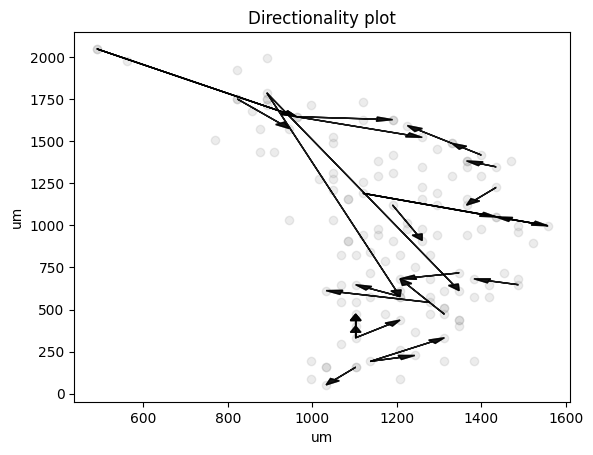

In [62]:
# Set up figure
plt.figsize= (1,1)

plt.scatter(neuron_x, neuron_y, alpha = 0.15, c='grey')

# Plot each individual arrow
for i in range(len(lates_directed)):
    
    # Get starting and ending arrow based on direction
    is_pos = np.median(lates_directed[i])>0
    if is_pos:
        start_i =  pairs_directed[i][0]
        end_i = pairs_directed[i][1]
    else:
        start_i =  pairs_directed[i][1]
        end_i = pairs_directed[i][0] 
    
    # plot dummy points, delete this soon  
#      plt.scatter( neuron_x[start_i], neuron_y[start_i], alpha=.1, c='b', s = 100)
#    plt.scatter( neuron_x[end_i], neuron_y[end_i], alpha=.1, c='r', s = 100 )
    
#     plt.scatter(neuron_x, neuron_y, alpha=.1)
    
    # add arrow
    arrow = FancyArrow( neuron_x[end_i], neuron_y[end_i], neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i], length_includes_head=True, head_width=25,
                                       linewidth=1, color='black', alpha=0.7, edgecolor='black', facecolor='black')
    plt.gca().add_patch(arrow)

plt.xlabel('um')
plt.ylabel('um')
plt.title("Directionality plot")  # Adding the title
plt.show()

/tmp/ipykernel_1606739/2655578977.py:36: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrow(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


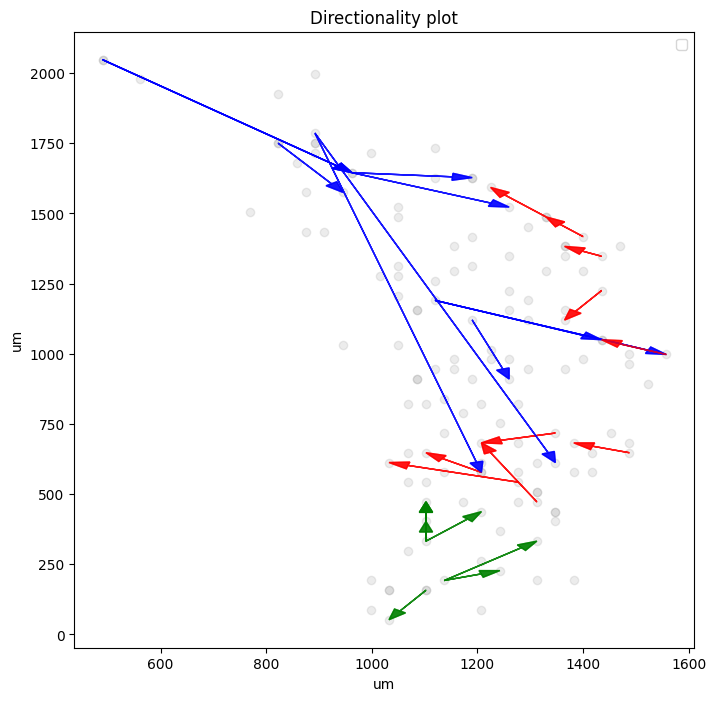

In [92]:
# Set up figure
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

plt.scatter(neuron_x, neuron_y, alpha=0.15, c='grey')

# Plot each individual arrow
for i in range(len(lates_directed)):
    
    # Get starting and ending arrow based on direction
    is_pos = np.median(lates_directed[i]) > 0
    if is_pos:
        start_i = pairs_directed[i][0]
        end_i = pairs_directed[i][1]
    else:
        start_i = pairs_directed[i][1]
        end_i = pairs_directed[i][0]

        
    arrow_color="black"
    if (neuron_y[start_i] < 500 or neuron_y[end_i] < 500):
        arrow_color="green"
        print(start_i)
        
    if neuron_x[start_i] < neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
        arrow_color="red"
    
    if neuron_x[start_i] > neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
        arrow_color = "blue"
        
        #         continue
        
    #if neuron_y[start_i] < neuron_y[end_i]:
    #    continue
   
    #arrow_color="black"
    # Add arrow
    arrow = FancyArrow(
        neuron_x[end_i], neuron_y[end_i],
        neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i],
        length_includes_head=True, head_width=25,
        linewidth=1, color=arrow_color, alpha=0.7, edgecolor=arrow_color, facecolor=arrow_color)
    plt.gca().add_patch(arrow)
    

plt.xlabel('um')
plt.ylabel('um')
plt.title("Directionality plot")  # Adding the title
plt.show()

### print euclidean distance

In [39]:
pairs = []

# Plot each individual arrow
for i in range(len(lates_directed)):
    
    # Get starting and ending arrow based on direction
    is_pos = np.median(lates_directed[i])>0
    if is_pos:
        start_i =  pairs_directed[i][0]
        end_i = pairs_directed[i][1]
    else:
        start_i =  pairs_directed[i][1]
        end_i = pairs_directed[i][0] 
    
    pair_distance = np.sqrt( (neuron_x[end_i] - neuron_x[start_i] )**2 + (neuron_y[end_i] - neuron_y[start_i] )**2 )
    pairs.append(pair_distance)
    print(pair_distance)
    

221.35943621178654
234.7871376374779
144.30869689661813
344.7100230628637
477.9775099311682
126.19429464123962
344.7100230628637
133.2760293526184
213.6147232753398
78.26237921249263
1247.9107540204948
126.19429464123962
126.19429464123962
477.9775099311682
133.2760293526184
126.19429464123962
70.0
140.0
98.99494936611666
620.695174783887
620.695174783887
126.19429464123962
110.67971810589327
224.1093483101497
126.19429464123962
98.99494936611666
228.1720841820927
148.49242404917499
1247.9107540204948
1257.6888526181665
110.67971810589327
213.6147232753398
110.67971810589327
234.7871376374779
620.695174783887
620.695174783887
144.30869689661813
70.0
70.0
228.1720841820927
321.7335854398791
78.26237921249263
148.49242404917499
148.49242404917499
254.80384612481814
254.80384612481814
321.7335854398791
224.1093483101497
221.35943621178654
140.0
70.0
148.49242404917499
1257.6888526181665
110.67971810589327


In [41]:
len(pairs)

54

In [43]:
len(np.unique(pairs))

21

## ELLIOTT

In [93]:
blue_lates=[]
red_lates =[]
green_lates=[]


# Plot each individual arrow
for i in range(len(lates_directed)):
    
    # Get starting and ending arrow based on direction
    is_pos = np.median(lates_directed[i]) > 0
    if is_pos:
        start_i = pairs_directed[i][0]
        end_i = pairs_directed[i][1]
    else:
        start_i = pairs_directed[i][1]
        end_i = pairs_directed[i][0]

        
    #arrow_color="black"
    if (neuron_y[start_i] < 500 or neuron_y[end_i] < 500):
        green_lates.append( sd.latencies_to_index(end_i)[start_i]  )
        #arrow_color="green"
        #print(start_i)
        
    if neuron_x[start_i] < neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
        #arrow_color="red"
        red_lates.append( sd.latencies_to_index(end_i)[start_i]  )
    
    if neuron_x[start_i] > neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
        #arrow_color = "blue"
        blue_lates.append( sd.latencies_to_index(end_i)[start_i]  )
        
        #         continue

In [130]:
def plot_latency_histograms_for_random_pairs(lates_all, threshold=0.3):#, num_random_pairs=4):
    #neuron_pairs = np.array(pairs)

    # Get 'num_random_pairs' random indices to choose random neuron pairs
    #random_indices = np.random.choice(neuron_pairs.shape[0], num_random_pairs, replace=False)
    random_indices=[4,5,6,7]
    #random_neuron_pairs = neuron_pairs[random_indices]

    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    axs = axs.ravel()

    for i in range(4):#i, neuron_pair in enumerate(random_neuron_pairs):
        #neuron1, neuron2 = neuron_pair
        #lates_n1 = sd.latencies_to_index(neuron1)
        lates_raw = lates_all[random_indices[i]]
        lates = list(filter(lambda x: x < 10 and x > -10, lates_raw))

        mean_latency = np.mean(lates)
        std_latency = np.std(lates)
        cutoff = 2 * std_latency

        # Remove values more than 2 standard deviations away from mean
        lates_filtered = [latency for latency in lates if abs(latency - mean_latency) <= cutoff]

        axs[i].hist(lates_filtered, bins=12, alpha=0.7, label='Latency')
        axs[i].axvline(mean_latency, color='red', linestyle='dashed', linewidth=2, label='Mean')
        axs[i].axvline(mean_latency - std_latency, color='green', linestyle='dashed', linewidth=2, label='Std -')
        axs[i].axvline(mean_latency + std_latency, color='green', linestyle='dashed', linewidth=2, label='Std +')
        axs[i].axvline(0, color='black', linestyle='dashed', linewidth=0.5, label='Std +')
        #axs[i].set_xlim(-0.5, 0.5)
        axs[i].set_xlim(-1*(abs(mean_latency)+cutoff), abs(mean_latency) + cutoff) 
        #axs[i].set_ylim( , abs(mean_latency)+cutoff )
        axs[i].set_xlabel("Latency (ms)")
        axs[i].set_ylabel("Number of spike pairs")
        axs[i].set_title(f"{round(100*(len(lates_filtered)/len(lates_raw)))}% kept")
#         axs[i].legend()

    plt.tight_layout()
    plt.show()

# # Call the function with your SpikeData object, the desired STTC threshold, and the number of random pairs to plot
# plot_latency_histograms_for_random_pairs, threshold=0.3, num_random_pairs=4)

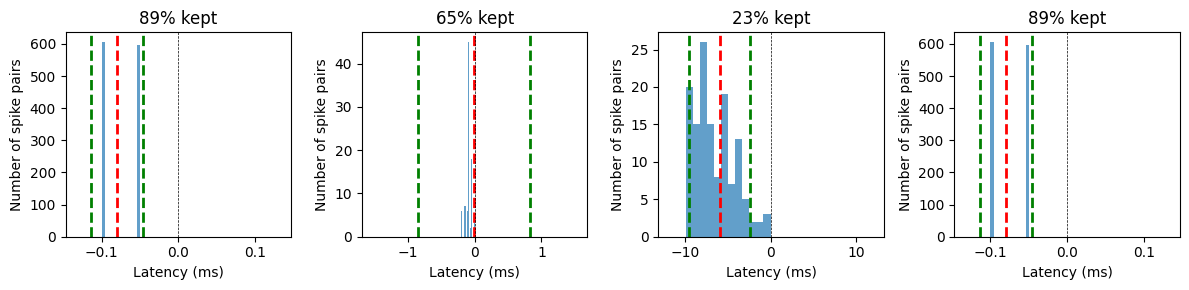

In [132]:
# Call the function with your SpikeData object, the desired STTC threshold, and the number of random pairs to plot
plot_latency_histograms_for_random_pairs(green_lates)

### plot

/tmp/ipykernel_1135338/2677915455.py:6: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrow( neuron_x[end_i], neuron_y[end_i], neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i], length_includes_head=True, head_width=3,


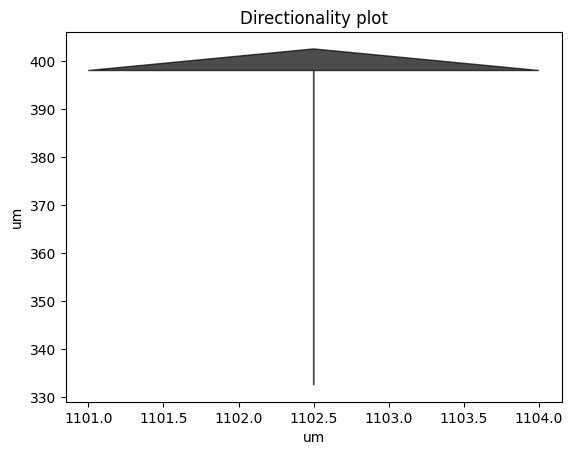

In [54]:
#fig, ax = plt.subplots(figsize=(8, 6))
plt.figsize= (8,6)
plt.scatter( neuron_x[start_i], neuron_y[start_i], alpha=0 )
#plt.xlim(500,1600)
#plt.ylim(0,2200)
arrow = FancyArrow( neuron_x[end_i], neuron_y[end_i], neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i], length_includes_head=True, head_width=3,
                                   linewidth=1, color='black', alpha=0.7, edgecolor='black', facecolor='black')
plt.gca().add_patch(arrow)


plt.xlabel('um')
plt.ylabel('um')
plt.title("Directionality plot")  # Adding the title
plt.show()

/tmp/ipykernel_1135338/3483360784.py:3: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrow(neuron_x[end_i], neuron_y[end_i], neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i],


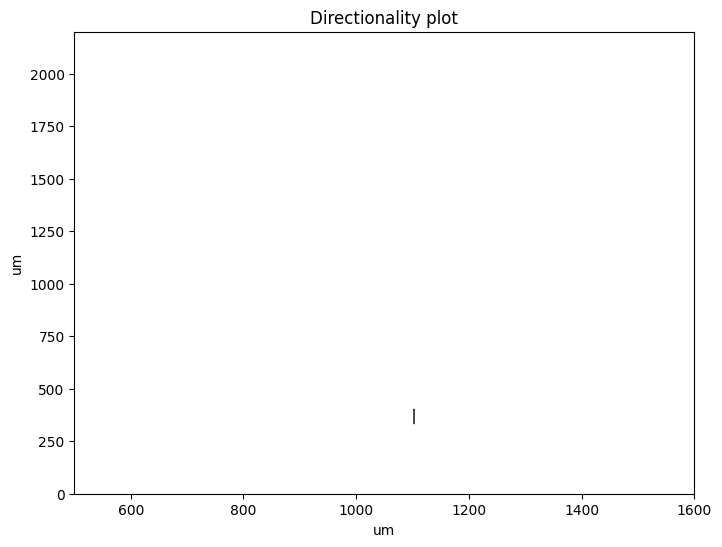

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(neuron_x[start_i], neuron_y[start_i], alpha=0)
arrow = FancyArrow(neuron_x[end_i], neuron_y[end_i], neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i],
                   length_includes_head=True, head_width=3, linewidth=1, color='black', alpha=0.7, edgecolor='black', facecolor='black')
ax.add_patch(arrow)
plt.xlim(500, 1600)
plt.ylim(0, 2200)
ax.set_xlabel('um')
ax.set_ylabel('um')
ax.set_title("Directionality plot")  # Adding the title
plt.show()

### <font color="brown">reference code

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(neuron_x, neuron_y, s=neuron_amp, c=upd_node_info)
threshold = thresh
sttc = inp_sd.spike_time_tilings()
for i in range(sttc.shape[0]):
    for j in range(sttc.shape[1]):
        if i <= j:
            continue
        if sttc[i, j] < threshold:
            continue
#             if i in [7, 10, 16, 43, 48, 66, 67]:
#                 continue
#             if j in [7, 10, 16, 43, 48, 66, 67]:
            continue
        ix, iy = inp_sd.neuron_data[0][i]['position']
        jx, jy = inp_sd.neuron_data[0][j]['position']
        linewidth = 1.5 + 2 * (sttc[i, j] - threshold)
        opacity = 0.2 + 0.8 * (sttc[i, j] - threshold)
        if upd_node_info[i] == 'blue' and upd_node_info[j] == 'red':
            linewidth = 2.0  # Set a thicker linewidth
            arrow = FancyArrow(jx, jy, ix - jx, iy - jy, length_includes_head=True, head_width=35,
                               linewidth=linewidth, color='black', alpha=0.7, edgecolor='black', facecolor='black')
            plt.gca().add_patch(arrow)
        else:
            ax.plot([ix, jx], [iy, jy], linewidth=linewidth, color='grey', alpha=opacity)
ax.set_xlabel('um')
ax.set_ylabel('um')
ax.set_title("Directionality plot")  # Adding the title

In [ ]:
arrow = FancyArrow(jx, jy, ix - jx, iy - jy, length_includes_head=True, head_width=2,
                                   linewidth=1, color='black', alpha=0.7, edgecolor='black', facecolor='black')
                plt.gca().add_patch(arrow)

# <font color="gray">reference code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_latency_histograms_for_random_pairs(sd, threshold=0.3, num_random_pairs=30):
    neuron_pairs = find_sttc_above_threshold(sd, threshold)

    # Get 'num_random_pairs' random indices to choose random neuron pairs
    random_indices = np.random.choice(neuron_pairs.shape[0], num_random_pairs, replace=False)
    random_neuron_pairs = neuron_pairs[random_indices]
    
    fig, axs = plt.subplots(8, 8, figsize=(30, 30))
    axs = axs.ravel()

    # Collect latency data from all neuron pairs
    all_lates = []

    for i, neuron_pair in enumerate(random_neuron_pairs):
        neuron1, neuron2 = neuron_pair
        lates_n1 = sd.latencies_to_index(neuron1)
        lates_raw = lates_n1[neuron2]
        lates = list(filter(lambda x: x < 10 and x > -10, lates_raw))

        all_lates.extend(lates)  # Collect all latencies for setting common axis limits

        mean_latency = np.mean(lates)
        std_latency = np.std(lates)

        axs[i].hist(lates, bins=10, alpha=0.7, label='Latency')
        axs[i].axvline(mean_latency, color='red', linestyle='dashed', linewidth=2, label='Mean')
        axs[i].axvline(mean_latency - std_latency, color='green', linestyle='dashed', linewidth=2, label='Std -')
        axs[i].axvline(mean_latency + std_latency, color='green', linestyle='dashed', linewidth=2, label='Std +')

        axs[i].set_xlabel("Latency (ms)")
        axs[i].set_ylabel("Number of spike pairs")
        axs[i].set_title(f"Latency Histogram - Neuron Pair {neuron1} and {neuron2}")

    # Calculate common axis limits from all latencies
    common_x_limit = (-10, 10)  # You can adjust the range if needed
    common_y_limit = (0, len(all_lates)//10)  # Dividing by 10 just to set a reasonable range for the y-axis

    # Set common axis limits for all subplots
    for ax in axs:
        ax.set_xlim(common_x_limit)
        ax.set_ylim(common_y_limit)

    # Hide unused subplots
    for i in range(num_random_pairs, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.savefig('LatencyDistributions.png')
    plt.show()

# Call the function with your SpikeData object, the desired STTC threshold, and the number of random pairs to plot
plot_latency_histograms_for_random_pairs(sd, threshold=0.48, num_random_pairs=64)